In [1]:
from __future__ import annotations
import xarray as xr
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import logging
import numpy as np
import pandas as pd
import xarray as xr
import pv_functions
import os
import glob
import os
import re
import cftime

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable albedo as the horizontal dimensions for the regridding.
  warnings.warn(


In [2]:
models = ["CanESM5"]  # Test with only one model
variants = ["r1i1p2f1"]  # Corresponding variant for the model
period = ["historical"]
base_path="/groups/FutureWind/SFCRAD/"
orientation1='latitude_optimal'
trigon_model='simple'
clearsky_model='simple'
tracking=None
panel = {
    "model": "huld",  # Model type
    "name": "CSi",  # Panel name
    "source": "Huld 2010",  # Source of the model

    # Used for calculating capacity per m2
    "efficiency": 0.1,  # Efficiency of the panel

    # Panel temperature coefficients
    "c_temp_amb": 1,  # Panel temperature coefficient of ambient temperature
    "c_temp_irrad": 0.035,  # Panel temperature coefficient of irradiance (K / (W/m2))

    # Reference conditions
    "r_tamb": 293,  # Reference ambient temperature (20 degC in Kelvin)
    "r_tmod": 298,  # Reference module temperature (25 degC in Kelvin)
    "r_irradiance": 1000,  # Reference irradiance (W/m^2)

    # Fitting parameters
    "k_1": -0.017162,
    "k_2": -0.040289,
    "k_3": -0.004681,
    "k_4": 0.000148,
    "k_5": 0.000169,
    "k_6": 0.000005,

    # Inverter efficiency
    "inverter_efficiency": 0.9
}
output_dir = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"




In [3]:
def collect_files(base_path, models, variants, periods):
    files_model = {}

    # Define the year ranges for each period
    year_ranges = {
        "historical": range(1980, 2015),  # 2014 included
        "ssp585": range(2065, 2100)       # 2099 included
    }
    for model, variant in zip(models, variants):
        model_files = {}
        for period in periods:
            # Construct the path
            search_path = os.path.join(base_path, model, period, variant)
            # Match files with the desired pattern
            file_pattern = os.path.join(search_path, "rsds_rsdsdiff_tas_*.nc")
            matched_files = glob.glob(file_pattern)

            # Filter files by year
            filtered_files = []
            for file_path in matched_files:
                filename = os.path.basename(file_path)
                # Extract year from filename
                match = re.search(r"(\d{4})", filename)
                if match:
                    year = int(match.group(1))
                    if year in year_ranges[period]:
                        filtered_files.append(file_path)

            model_files[period] = filtered_files
        files_model[model] = model_files

    return files_model

In [4]:
files=collect_files(base_path, models, variants, period)
for model in files:
   for period in files[model]:
      files[model][period] = [
         file for file in files[model][period] if "1988" in file  # Replace "1988" with the year you want to test
    ]

In [25]:
for model, periods in files.items():
        print(f"Processing model: {model}")
        for period, file_list in periods.items():
            print(f"  Processing Period: {period}")
            for file_path in file_list:
                    print(f"    Processing file: {file_path}")
                    
                    # Prepare output directory and filenames
                    output_dir_period = os.path.join(output_dir, model, period)
                    os.makedirs(output_dir_period, exist_ok=True)  # Ensure the output directory exists
                    
                    file_name = os.path.basename(file_path)
                    # Replace "rsds_rsdsdiff_tas" with "solar_power"
                    file_name = file_name.replace("rsds_rsdsdiff_tas", "solar_power")
                    output_file = os.path.join(output_dir_period, file_name)
                    
                    # Check if the solar power file already exists
                    if os.path.exists(output_file):
                        print(f"    Skipping {file_path} as {output_file} already exists.")
                        continue
                    
                    # Prepare aggregated generation file name
                    file_name_agg = file_name + "_aggregated"
                    output_file_agg = os.path.join(output_dir_period, file_name_agg)
                    
                    # Check if the aggregated generation file already exists
                    if os.path.exists(output_file_agg):
                        print(f"    Skipping {file_path} as {output_file_agg} already exists.")
                        continue

                    # Extract the year as a string for later
                    year = int(re.search(r"(\d{4})", file_name).group(1))
                    
                    # Open the file
                    #for H models and gregorian: 
                    #ds = xr.open_dataset(file_path, engine="netcdf4", decode_times=False)
                    ds = xr.open_dataset(file_path, engine="netcdf4", decode_times=True)
                    print('File opened')

Processing model: CanESM5
  Processing Period: historical
    Processing file: /groups/FutureWind/SFCRAD/CanESM5/historical/r1i1p2f1/rsds_rsdsdiff_tas_1988.nc
File opened


In [26]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:   (time: 2920, lat: 20, lon: 28)
Coordinates:
  * lon       (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
  * lat       (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time      (time) object 23kB 1988-01-01 01:30:00 ... 1988-12-31 22:30:00
Data variables:
    rsds      (time, lat, lon) float32 7MB ...
    rsdsdiff  (time, lat, lon) float32 7MB ...
    tas       (time, lat, lon) float32 7MB ...
Attributes:
    data_source:    Processed data from CMIP6 runs
    experiment:     historical
    source:         CanESM5
    variant_label:  r1i1p2f1
    data_written:   12/03/2025 14:04

In [7]:
def is_leap_year(year):
    """
    Check if a year is a leap year in the Gregorian calendar.
    
    Parameters:
        year (int): The year to check.
    
    Returns:
        bool: True if the year is a leap year, False otherwise.
    """
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

In [8]:
def transform_to_gregorian(ds, year):
    """
    Transform a dataset with a 360-day calendar to a Gregorian calendar.
    
    Parameters:
        ds (xarray.Dataset): The dataset with a 360-day calendar.
        year (int): The year being processed.
    
    Returns:
        xarray.Dataset: The transformed dataset with a Gregorian calendar.
    """

    # Step 1: Build the new time index
    new_times = []
    for month in range(1, 13):
        if month == 2:
            days = 29 if is_leap_year(year) else 28
        elif month in [4, 6, 9, 11]:
            days = 30
        else:
            days = 31
        for day in range(1, days + 1):
            new_times.append(cftime.DatetimeGregorian(year, month, day))
    
    new_time_index = xr.DataArray(new_times, dims="time")

    # Step 2: Interpolate or match
    # Original time axis: assume it's equally spaced 360 days
    old_times = np.linspace(0, 1, ds.dims["time"], endpoint=False)  # normalized
    new_times_norm = np.linspace(0, 1, len(new_time_index), endpoint=False)

    # Reassign normalized time
    ds = ds.assign_coords(time=("time", old_times))
    
    # Interpolate onto new normalized time
    ds_interp = ds.interp(time=new_times_norm)

    # Replace the interpolated normalized time with real Gregorian dates
    ds_interp = ds_interp.assign_coords(time=new_time_index)

    return ds_interp

In [28]:
def add_february_29(ds, year):
    """
    Add February 29 to a dataset with a noleap calendar by duplicating all Feb 28 timestamps.
    Handles 3-hourly (or any sub-daily) datasets correctly.
    """
    import numpy as np
    import pandas as pd
    import xarray as xr

    if is_leap_year(year):
        if not np.issubdtype(ds['time'].dtype, np.datetime64):
            try:
                ds['time'] = pd.to_datetime([
                    f"{t.year:04}-{t.month:02}-{t.day:02} {t.hour:02}:{t.minute:02}:{t.second:02}"
                    for t in ds['time'].values
                ])
            except Exception as e:
                raise ValueError(f"Failed to convert time to datetime64[ns]: {e}")

        # Select Feb 28 times
        feb_28 = ds.sel(time=(ds['time'].dt.month == 2) & (ds['time'].dt.day == 28))

        if feb_28.time.size > 0:
            # Duplicate Feb 28 and shift by +1 day
            feb_29 = feb_28.copy()
            feb_29 = feb_29.assign_coords(time=feb_28['time'] + pd.Timedelta(days=1))

            ds = xr.concat([ds, feb_29], dim="time")
            ds = ds.sortby('time')
        else:
            print(f"Warning: February 28 not found for year {year}")

    return ds




In [27]:
print(ds['time'].values)
print(ds['time'].diff('time'))


[cftime.DatetimeNoLeap(1988, 1, 1, 1, 30, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1988, 1, 1, 4, 30, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1988, 1, 1, 7, 30, 0, 0, has_year_zero=True) ...
 cftime.DatetimeNoLeap(1988, 12, 31, 16, 30, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1988, 12, 31, 19, 30, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1988, 12, 31, 22, 30, 0, 0, has_year_zero=True)]
<xarray.DataArray 'time' (time: 2919)> Size: 23kB
array([10800000000000, 10800000000000, 10800000000000, ...,
       10800000000000, 10800000000000, 10800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) object 23kB 1988-01-01 04:30:00 ... 1988-12-31 22:30:00


In [29]:
if model in ["HadGEM3-GC31-LL", "HadGEM3-GC31-MM"]:
    ds = transform_to_gregorian(ds, year)
elif model in ["CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2"]:
    ds = add_february_29(ds, year)
else:
    # Decode time normally for other models
    ds = xr.decode_cf(ds)
print('Time decoded')

Time decoded


In [30]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:   (time: 2928, lat: 20, lon: 28)
Coordinates:
  * lon       (lon) float32 112B -28.12 -25.31 -22.5 -19.69 ... 42.19 45.0 47.81
  * lat       (lat) float32 80B 20.93 23.72 26.51 29.3 ... 68.37 71.16 73.95
  * time      (time) datetime64[ns] 23kB 1988-01-01T01:30:00 ... 1988-12-31T2...
Data variables:
    rsds      (time, lat, lon) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rsdsdiff  (time, lat, lon) float32 7MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tas       (time, lat, lon) float32 7MB 295.7 295.4 294.5 ... 252.2 250.2
Attributes:
    data_source:    Processed data from CMIP6 runs
    experiment:     historical
    source:         CanESM5
    variant_label:  r1i1p2f1
    data_written:   12/03/2025 14:04

In [34]:
ds['time'].sel(time='1988-02').values

array(['1988-02-01T01:30:00.000000000', '1988-02-01T04:30:00.000000000',
       '1988-02-01T07:30:00.000000000', '1988-02-01T10:30:00.000000000',
       '1988-02-01T13:30:00.000000000', '1988-02-01T16:30:00.000000000',
       '1988-02-01T19:30:00.000000000', '1988-02-01T22:30:00.000000000',
       '1988-02-02T01:30:00.000000000', '1988-02-02T04:30:00.000000000',
       '1988-02-02T07:30:00.000000000', '1988-02-02T10:30:00.000000000',
       '1988-02-02T13:30:00.000000000', '1988-02-02T16:30:00.000000000',
       '1988-02-02T19:30:00.000000000', '1988-02-02T22:30:00.000000000',
       '1988-02-03T01:30:00.000000000', '1988-02-03T04:30:00.000000000',
       '1988-02-03T07:30:00.000000000', '1988-02-03T10:30:00.000000000',
       '1988-02-03T13:30:00.000000000', '1988-02-03T16:30:00.000000000',
       '1988-02-03T19:30:00.000000000', '1988-02-03T22:30:00.000000000',
       '1988-02-04T01:30:00.000000000', '1988-02-04T04:30:00.000000000',
       '1988-02-04T07:30:00.000000000', '1988-02-04

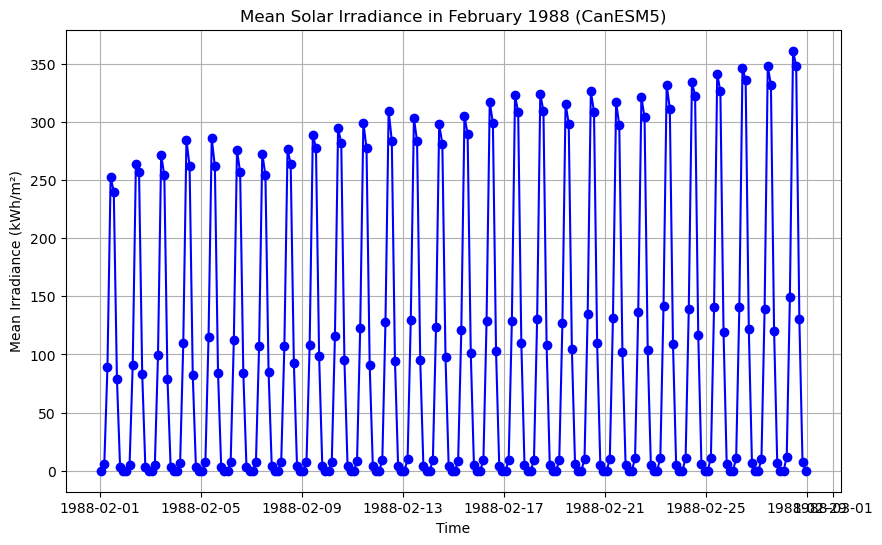

In [32]:
import matplotlib.pyplot as plt
import xarray as xr

# Extract the variable and filter for February 1988
solar_irradiance = ds['rsds'].sel(time=slice('1988-02-01', '1988-02-28'))

# Aggregate over latitude and longitude (mean irradiance for each time step)
mean_irradiance = solar_irradiance.mean(dim=['lat', 'lon'])

# Plot time vs. mean irradiance
plt.figure(figsize=(10, 6))
plt.plot(mean_irradiance['time'], mean_irradiance, marker='o', linestyle='-', color='b')
plt.title("Mean Solar Irradiance in February 1988 (CanESM5)")
plt.xlabel("Time")
plt.ylabel("Mean Irradiance (kWh/m²)")
plt.grid(True)
plt.show()

In [ ]:
diri="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2/"
aggregated=xr.open_dataset()

In [9]:
import xarray as xr

# Define the directory and file paths
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2/"
field = "specific generation"
path = f"{diri}/historical/"
files = [f"{path}solar_power_{year}.nc_aggregated" for year in range(1980, 2015)]

# Open each file and assign a time coordinate as the year
datasets = []
for year, file in zip(range(1980, 2015), files):
    ds = xr.open_dataset(file)
    ds = ds.expand_dims(time=[year])  # Add a time dimension with the year as an integer
    datasets.append(ds)

# Combine all datasets along the time dimension
combined_ds = xr.concat(datasets, dim="time")

# Calculate the mean across all years
mean_power = combined_ds[field].mean(dim="time")

# Save the result to a new NetCDF file (optional)
mean_power.to_netcdf(f"{path}mean_solar_power_1980_2014.nc")

# Print the result
print(mean_power)

<xarray.DataArray 'specific generation' (lat: 26, lon: 25)> Size: 5kB
array([[1594.55141214, 1679.33509031, 1712.66156678, 1789.98482143,
        1903.27997165, 1825.82089659, 1863.87162288, 1896.67869793,
        1867.2948552 , 1824.9230756 , 1812.78365786, 1834.70739083,
        1728.97257944, 1705.89514192, 1739.77724697, 1737.82871614,
        1724.25631513, 1714.10902819, 1764.08757657, 1760.8555484 ,
        1744.85131332, 1760.78318448, 1738.42367683, 1722.50238862,
        1290.17202111],
       [1431.24441737, 1493.86960545, 1525.80788566, 1551.36959532,
        1669.95495157, 1677.27457677, 1650.11670885, 1677.02243816,
        1695.06414856, 1652.57974244, 1667.25061064, 1625.48832324,
        1570.39703895, 1556.3812165 , 1596.32635959, 1583.19778898,
        1567.34384995, 1569.54901709, 1627.8636872 , 1642.11892458,
        1621.54488565, 1640.33201638, 1606.35334323, 1588.12986393,
        1440.58450464],
       [1387.66983785, 1476.08006884, 1489.28371885, 1434.63477879

In [21]:
import xarray as xr
# Define the directory and file paths
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL/"
field = "specific generation"
path = f"{diri}/ssp585/"
files = [f"{path}solar_power_{year}.nc_aggregated" for year in range(2065, 2100)]

# Open each file and assign a time coordinate as the year
datasets = []
for year, file in zip(range(2065, 2100), files):
    ds = xr.open_dataset(file,engine="netcdf4")
    ds = ds.expand_dims(time=[year])  # Add a time dimension with the year as an integer
    datasets.append(ds)

# Combine all datasets along the time dimension
combined_ds = xr.concat(datasets, dim="time")

# Calculate the mean across all years
mean_power_EOC = combined_ds[field].mean(dim="time")

# Save the result to a new NetCDF file (optional)
mean_power_EOC.to_netcdf(f"{path}mean_solar_power_2065_2100.nc")

# Print the result
print(mean_power_EOC)

<xarray.DataArray 'specific generation' (lat: 26, lon: 25)> Size: 5kB
array([[856.42962086, 895.05172138, 915.62985454, 932.93214427,
        990.54320043, 937.81187395, 950.86369653, 966.23150461,
        947.61834372, 911.77788757, 890.07302153, 918.19605705,
        858.70505201, 854.69784655, 873.50258539, 879.53398531,
        886.53971232, 871.85630409, 895.92440984, 901.33898898,
        876.82401378, 875.15009797, 862.50615958, 862.47124842,
        661.65709325],
       [761.7880659 , 782.35741386, 789.11286193, 782.10398837,
        842.11195315, 833.53610449, 833.54783141, 849.94812991,
        853.45663133, 817.15459739, 811.98823933, 800.18206187,
        790.86259974, 778.9204478 , 801.96669303, 805.28087019,
        800.69811186, 800.53992922, 825.03253665, 828.51736116,
        810.1607331 , 809.3691609 , 795.282795  , 800.88825995,
        765.08384116],
       [737.38713101, 759.21536202, 761.98183324, 723.96821111,
        757.90020195, 760.53870252, 773.94918084, 81

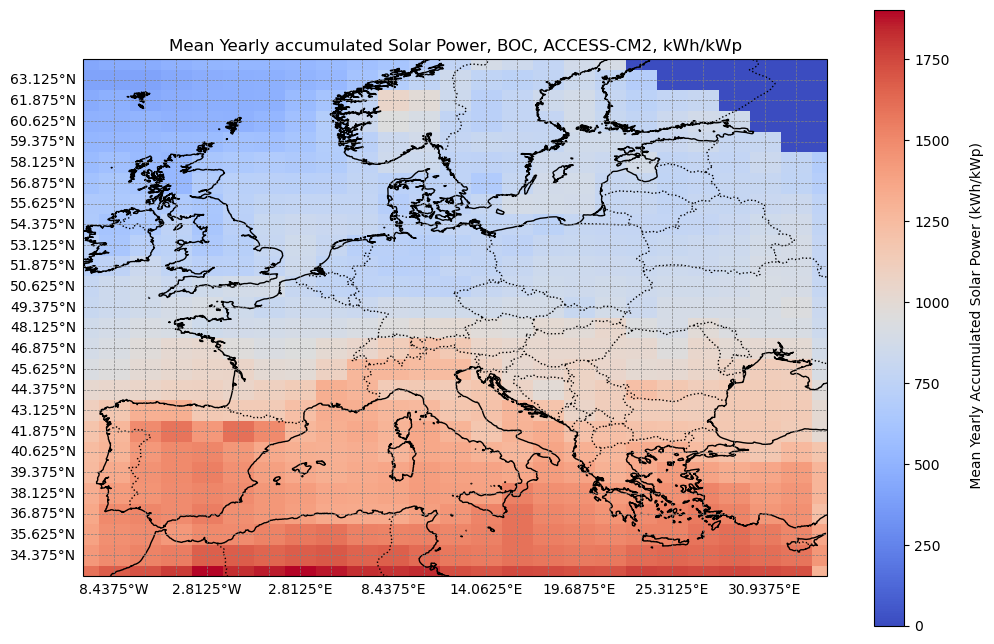

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Extract longitude, latitude, and the variable to plot
lon = mean_power.lon
lat = mean_power.lat  # Replace 'solar_power' with the actual variable name in ds_power

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot the solar power data
c = ax.pcolormesh(
    lon, lat, mean_power,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for solar power
    shading='auto',# Smooth shading
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Yearly accumulated Solar Power, BOC, ACCESS-CM2, kWh/kWp")

# Add gridlines aligned with x and y coordinates
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    x_inline=False, 
    y_inline=False
)
gridlines.xlocator = plt.FixedLocator(lon.values)  # Use longitude values for x gridlines
gridlines.ylocator = plt.FixedLocator(lat.values)  # Use latitude values for y gridlines

gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label(' Mean Yearly Accumulated Solar Power (kWh/kWp)', rotation=90, labelpad=15)

plt.show()